##### License: Attribution 4.0 International (CC BY 4.0) 
[https://creativecommons.org/licenses/by/4.0/](https://creativecommons.org/licenses/by/4.0/)

# CompBayes **Report 3**

#### By Andrea Jackson

### Allergic Dinner Problem (Chapter 5 exercise)

Suppose you are having a dinner party with 10 guests and 4 of them are allergic to cats. Because you have cats, you expect 50% of the allergic guests to sneeze during dinner. At the same time, you expect 10% of the non-allergic guests to sneeze. What is the distribution of the total number of guests who sneeze?

In [8]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Beta, MakeBinomialPmf, Joint, MakeJoint
import thinkplot

In [9]:
# the number of guests that are allergic
numAllergic = 4

# the number of guests that are not allergic
numNonAllergic = 6

# probability allergic guests will sneeze
probA_sneeze = 0.5

# probability non-Allergic guest will sneeze
probNA_sneeze = 0.1

In [10]:
allergicPmfB = MakeBinomialPmf(numAllergic, probA_sneeze)
nonAllergicPmfB = MakeBinomialPmf(numNonAllergic, probNA_sneeze)

# using Pmf.__add__ to enumerate all pairs of values between 
# allergicPmf and nonAllergicPmf and compute the sum and prob of each pair
total_sneezesB = allergicPmfB + nonAllergicPmfB

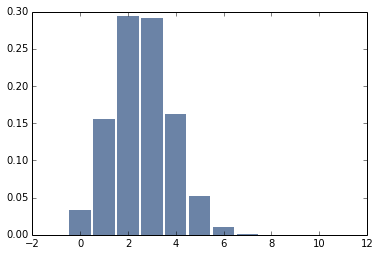

In [11]:
# The result is a distribution of the sum of two binomials or a convolution
# Two or three guests will most likely sneeze at the dinner party.
thinkplot.Hist(total_sneezesB)

### Improving reading ability problem (Chapter 9 exercise)

### Improving Reading Ability problem (Chapter 9 exercise)

From DASL(http://lib.stat.cmu.edu/DASL/Stories/ImprovingReadingAbility.html)

> An educator conducted an experiment to test whether new directed reading activities in the classroom will help elementary school pupils improve some aspects of their reading ability. She arranged for a third grade class of 21 students to follow these activities for an 8-week period. A control classroom of 23 third graders followed the same curriculum without the activities. At the end of the 8 weeks, all students took a Degree of Reading Power (DRP) test, which measures the aspects of reading ability that the treatment is designed to improve.

> Summary statistics on the two groups of children show that the average score of the treatment class was almost ten points higher than the average of the control class. A two-sample t-test is appropriate for testing whether this difference is statistically significant. The t-statistic is 2.31, which is significant at the .05 level.

#### All of the code in the cell below is from Allen Downey's ThinkBayes Chapter 9 notebook.

In [12]:
import pandas as pd
df = pd.read_csv('drp_scores.csv', skiprows=22, delimiter='\t')

from scipy.stats import norm

# multiple inheritance
class Normal(Suite, Joint):
    def Likelihood(self, data, hypo):
        """
        data: sequence of test scores
        hypo: mu, sigma
        """
        mu, sigma = hypo
        likes = norm.pdf(data, mu, sigma) # produces a likelihood for each data
        return np.prod(likes) # produces a product of the likelihood
    
from itertools import product # returns all the possible selections from a sequence
mus = np.linspace(20, 80, 101) # 101 values that are equally spaced from 20 to 80
sigmas = np.linspace(5, 30, 101) # 101 values are equally spaced from 5 to 30

control = Normal(product(mus, sigmas))
data = df[df.Treatment=='Control'].Response
control.Update(data) # returns total likelihood of data

pmf_mu0 = control.Marginal(0)
pmf_sigma0 = control.Marginal(1)

### **Exercise**: 
Run this analysis again for the control group.  What is the distribution of the difference between the groups?  What is the probability that the average "reading power" for the treatment group is higher?  What is the probability that the variance of the treatment group is higher?

In [13]:
treatment = Normal(product(mus, sigmas))
# create a dataframe of the treatment group
data_treatment = df[df.Treatment=='Treated'].Response 
treatment.Update(data_treatment) # returns total likelihood of data

4.5285690956159087e-37

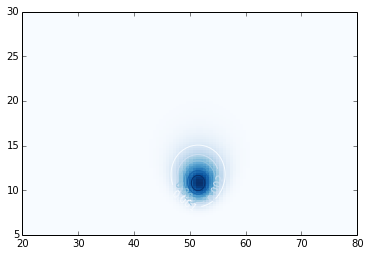

In [14]:
# contour plot of the treatment group
thinkplot.Contour(treatment, pcolor=True)

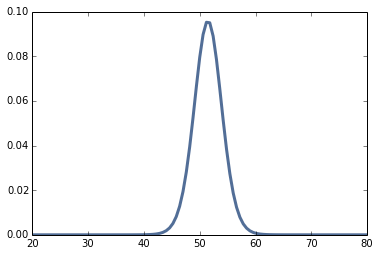

In [15]:
# the marginal distribution of the treatment group's mu (mean)
pmf_mu1 = treatment.Marginal(0)
thinkplot.Pdf(pmf_mu1)

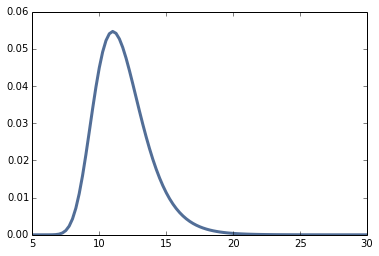

In [16]:
# the marginal distribution of the treatment group's sigma (standard deviation)
pmf_sigma1 = treatment.Marginal(1)
thinkplot.Pdf(pmf_sigma1)

#### What is the distribution of the difference between the groups?

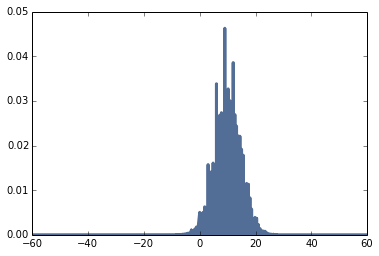

In [17]:
# using Pmf.__sub__ we can find the difference between the treatment and control group
diff_dist_mu = pmf_mu1 - pmf_mu0
thinkplot.Pdf(diff_dist_mu)

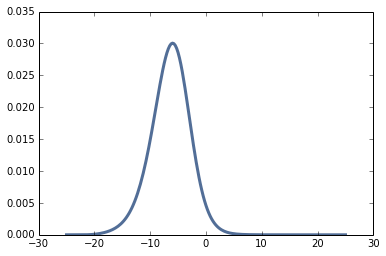

In [18]:
diff_dist_sigma = pmf_sigma1 - pmf_sigma0
thinkplot.Pdf(diff_dist_sigma)

In [19]:
jointDist = MakeJoint(diff_dist_mu,diff_dist_sigma)

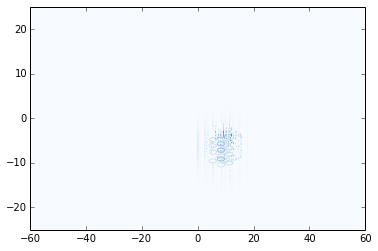

In [20]:
thinkplot.Contour(jointDist, pcolor=True)

#### What is the probability that the average "reading power" for the treatment group is higher?

In [21]:
from thinkbayes2 import *
PmfProbGreater(pmf_mu1,pmf_mu0)

0.98047902518732777

#### What is the probability that the variance of the treatment group is higher?

In [22]:
PmfProbGreater(pmf_sigma1,pmf_sigma0)

0.02688748111057556

### Lincoln index problem by John D. Cook (Chapter 9 exercise)

"Suppose you have a tester who finds 20 bugs in your program. You want to estimate how many bugs are really in the program. You know there are at least 20 bugs, and if you have supreme confidence in your tester, you may suppose there are around 20 bugs. But maybe your tester isn't very good. Maybe there are hundreds of bugs. How can you have any idea how many bugs there are? There’s no way to know with one tester. But if you have two testers, you can get a good idea, even if you don’t know how skilled the testers are.

"Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find. The Lincoln Index estimates the total number of errors as k1 k2 / c [I changed his notation to be consistent with mine]."

So if the first tester finds 20 bugs, the second finds 15, and they find 3 in common, we estimate that there are about 100 bugs. What is the Bayesian estimate of the number of errors based on this data?

In [133]:
from thinkbayes2 import EvalBinomialPmf, MakeUniformPmf
from scipy.stats import uniform, binom

k1 = 20 # number of bugs found by tester 1
k2 = 15 # number of bugs found by tester 2
c = 3 # the number of bugs found in common

data = (k1,k2,c)
# hypo is a tuple of n, p1, p2

In [134]:
class Lincoln(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        data: k1,k2,c
        hypo: n,p1,p2
        """
        n,p1,p2 = hypo
        k1,k2,c = data

        like1 = EvalBinomialPmf(k1, n, p1)
        like2 = EvalBinomialPmf(k2, n, p2)
        return like1*like2
    

### Original Problem

At least 1 original type 2 problem

Type 1: Simple to state, small number of hypotheses, prior is either explicit or uncontroversial.  
Examples: Elvis, dice, M&M, socks, etc.

Type 2: Might require more work to formulate, more hypotheses, prior might take some thought. 
Examples: train, Euro, Kim Rhode.

Type 3: Involves estimating multiple parameters and working with joint distributions.

### Update on final project

### Original plan: 
My partner for the final project is Yada. We want to do a final project related to survival analysis and MCMC. We are considering doing survival analysis on Airbnb properties. Check out Yada's report 3 for notes we created for survival analysis and a google doc of our other ideas for the final project. 

### Backup plan:
If our original plan ends up being unfeasible or just doesn't work, an idea for a back up plan is to analyze our gmail inboxes. As explained in Think Bayes Chapter 7, a Poisson process is "the continuous version of a Bernoulli process, where an event can occur at any point in time with equal probability". Receiving emails can be modelled by a Poisson process. I can create a timeseries of when I receive emails and use the timeseries to calculate lambda. With a poisson process, I can answer questions similar to those answered in Chapter 7. I haven't considered what specific interesting question(s) I could answer about my gmail inbox, but I'll determine one soon.